# Домашнее задание к лекции «Поиск выбросов и генерация новых признаков»

1. Теперь решаем задачу регрессии - предскажем цены на недвижимость. Использовать датасет https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data (train.csv)
2. Данных немного, поэтому необходимо использовать 10-fold кросс-валидацию для оценки качества моделей
3. Построить случайный лес, вывести важность признаков
4. Обучить стекинг как минимум 3х моделей, использовать хотя бы 1 линейную модель и 1 нелинейную
5. Для валидации модели 2-го уровня использовать отдельный hold-out датасет, как на занятии
6. Показать, что использование ансамблей моделей действительно улучшает качество (стекинг vs другие модели сравнивать на hold-out)
7. В качестве решения: Jupyter notebook с кодом, комментариями и графиками

In [ ]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


### Функции

In [ ]:
# Для поиска выбросов будем использовать boxplot, pairplot
def get_boxplot(X, columns=None):
  if columns is None:
    columns = X.columns

  for i in columns:
    sns.boxplot(x=X[i])
    plt.show()
  pass  

def get_pairplot(X, columns=None):
  if columns is None:
    columns = X.columns

  sns.pairplot(X[columns])
  pass

def get_hist(X, columns=None, bins='auto'):
  if columns is None:
    columns = X.columns

  for i in columns:
    sns.histplot(x=X[i], bins=bins)
    plt.grid()
    plt.show()
  pass

def get_heatmap(X, columns=None, target=None, thres=0.5):
  if columns is None:
    columns = X.columns

  # если задана целевая переменная - вывести только те переменные
  # из columns, у которых корреляция с целевой выше порога 
  if target is not None:
    columns = X[columns].corr().index[abs(X[columns].corr()[target]) > thres]
 
  sns.heatmap(X[columns].corr(), cmap='coolwarm', annot = True, )
  pass

# Решение

### Работа с датасетом

Воспользуемся результатами обработки датасета, выполненными в предыдущем домашнем задании:

In [ ]:
# датасет
data = pd.read_csv('train.csv')
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
#Находим категориальные признаки
cat_features = list(data.columns[data.dtypes == object])
int_features = list(set(data.columns) - set(cat_features))

In [ ]:
# заполняем пропуски, категориальные - новой категорией NaN, числовые - нулем
data[cat_features] = data[cat_features].fillna('NaN')
data[int_features] = data[int_features].fillna(0)

In [ ]:
# Логарифмируем данные переменные для исправления их нормального распределения:
data['SalePrice'] = np.log1p(data['SalePrice'])
data['GrLivArea'] = np.log1p(data['GrLivArea'])
data['1stFlrSF'] = np.log1p(data['1stFlrSF'])

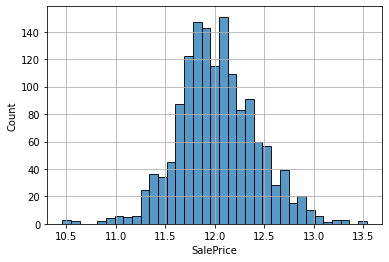

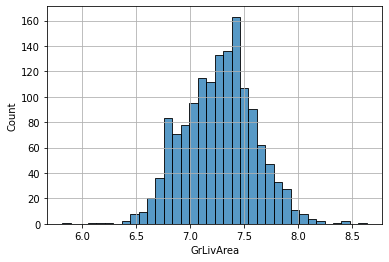

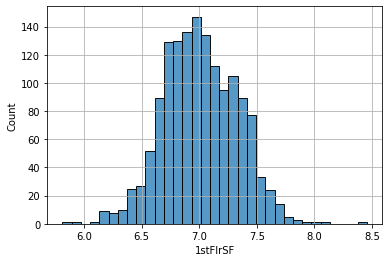

In [ ]:
get_hist(data, ['SalePrice'])
get_hist(data, ['GrLivArea'])
get_hist(data, ['1stFlrSF'])

In [ ]:
# Обрабатываем категориальные переменные, если категорий немного - применяем OneHotEncoding
from sklearn.preprocessing import LabelEncoder 
le = LabelEncoder()

for i  in cat_features:
    if len(data[i].unique()) < 8:
        data = pd.get_dummies(data, columns=[i])
    else:
        le.fit(data[i])
        data[i] = le.transform(data[i])

In [ ]:
# разбиваем данные на train и на test
y = data['SalePrice']
X = data.drop('SalePrice', axis=1)

### Разбиение на train, test, hold-out и нормирование

In [ ]:
from sklearn.model_selection import train_test_split
# выделяем отложенную выборку и обучающую
X_train, X_holdout, y_train, y_holdout = train_test_split(X.copy(), y.copy(), test_size=0.3, random_state=1)

# делаем нормирование
from sklearn.preprocessing import StandardScaler
stX = StandardScaler()
X_train.loc[:,:] = stX.fit_transform(X_train)
X_holdout.loc[:,:] = stX.transform(X_holdout)

# обучающую делим на трейн и тест
#X_train, X_test, y_train, y_test = train_test_split(X_train_full, y_train_full, test_size=0.3, random_state=1) 

###  Случайный лес, важность признаков

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
clf = RandomForestRegressor(max_depth=10, n_estimators=200)
clf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
# Выводим важность признаков
clf_feat = pd.Series(clf.feature_importances_, index=X_train.columns)
clf_feat.sort_values(ascending=False).head(10)

OverallQual    0.508080
GrLivArea      0.109280
GarageCars     0.071040
TotalBsmtSF    0.041991
GarageArea     0.030123
1stFlrSF       0.028958
BsmtFinSF1     0.024233
YearBuilt      0.019086
LotArea        0.014508
GarageYrBlt    0.013040
dtype: float64

### Реализуем стекинг

In [ ]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Lasso, LinearRegression, ARDRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings("ignore")

Линейной моделью будет Lasso, в стекинг также включим алгоритм случайного леса RandomForestRegressor и модель XGBRegressor.

Итоговым регрессором трех моделей будет модель ARDRegression (захотелось чего-то экзотического)

In [ ]:
# Список моделей
model_1 = Lasso()
model_2 = RandomForestRegressor()
model_3 = XGBRegressor(objective='reg:squarederror')

final_model = ARDRegression()

In [ ]:
# Настраиваем стекинг-регрессор
regressor = StackingRegressor(
    [
     ('mod1', model_1),
     ('mod2', model_2),
     ('mod3', model_3)     
    ],
    final_model,
    cv=5)

In [ ]:
# обучение регрессора
regressor.fit(X_train, y_train)
regressor.final_estimator_

ARDRegression(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
              fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
              normalize=False, threshold_lambda=10000.0, tol=0.001,
              verbose=False)

In [ ]:
# Для оценки точности модели будем использовать 10-Fold кросс-валидацию
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

# разделение на фолды
cv = KFold(n_splits=10, shuffle=True, random_state=42)

def cv_rmse(model, X, y, cv):
    rmse = np.sqrt(-cross_val_score(model,
                                    X, y, 
                                    scoring="neg_mean_squared_error", 
                                    cv=cv)
    )
    return np.mean(rmse)

Проведем оценку точности моделей, используя кросс-валидацию на train-выборке и итоговой точностью будет среднее корня из всех среднеквадратичных отклонений (mean_squared_error)

In [ ]:
rmse_all = [cv_rmse(regressor.named_estimators_['mod1'], X_train, y_train, cv),
            cv_rmse(regressor.named_estimators_['mod2'], X_train, y_train, cv),
            cv_rmse(regressor.named_estimators_['mod3'], X_train, y_train, cv),
            cv_rmse(regressor, X_train, y_train, cv)
]

In [ ]:
rmse_all

[0.3818978304256229,
 0.14328557738044032,
 0.12996173435036082,
 0.1291869538908873]

Как видно, модель стекинга имеет самую низкую ошибку 0.1291869538908873

Проведем валидацию модели стекинга на отложенной выборке и посмотрим, как эта модель, а также подмодели себя на этой выборке ведут:

In [ ]:
from sklearn.metrics import mean_squared_error

def get_rmse(model, X_test, y_test):
  y_pred = model.predict(X_test)
  mse = mean_squared_error(y_test, y_pred)
  return np.sqrt(mse)

In [ ]:
# Просреднеквадратическая ошибка каждой из модели на отложенной выборке
rmse_all = [get_rmse(regressor.named_estimators_['mod1'], X_holdout, y_holdout),
            get_rmse(regressor.named_estimators_['mod2'], X_holdout, y_holdout),
            get_rmse(regressor.named_estimators_['mod3'], X_holdout, y_holdout),
            get_rmse(regressor, X_holdout, y_holdout)
]

In [ ]:
rmse_all

[0.43566761680580696,
 0.15787428451120242,
 0.14381455675367988,
 0.1410479986538138]

Ожидаемо, на отложенной выборке результаты получились с большей ошибкой, но модель стекинга при этом имеет выше качество, чем любая входящая в ансамбль.

Проиллюстрируем на графике размер ошибки каждой модели:

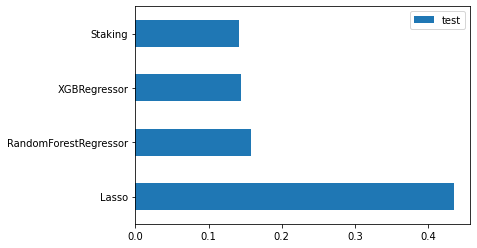

In [ ]:
pd.Series(list(rmse_all), index=['Lasso',
                                 'RandomForestRegressor',
                                 'XGBRegressor',
                                 'Staking']).plot(kind='barh', label='test')
plt.legend()
plt.show()